# Predicting Household Income Values in the Philippines
## Determining household income values through model pipelines.

This study aims to predict total household income among selected household in the Philippines. The usage of pipelines will be used in order to streamline the process and to create efficiency in generating results.

Shared by: Francis Paul Flores   
Source: Philippine Statistics Authority   
Link: https://www.kaggle.com/datasets/grosvenpaul/family-income-and-expenditure

In [1]:
# Import numpy and pandas libraries.
import numpy as np
import pandas as pd

# Set column display options to 100 see all columns.
pd.options.display.max_columns = 100

# Read the 'fies.csv' through pandas.
fies = pd.read_csv('fies.csv')

In [2]:
# Inspect the first 5 rows.
fies.head()

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Sex,Household Head Age,Household Head Marital Status,Household Head Highest Grade Completed,Household Head Job or Business Indicator,Household Head Occupation,Household Head Class of Worker,Type of Household,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,Type of Building/House,Type of Roof,Type of Walls,House Floor Area,House Age,Number of bedrooms,Tenure Status,Toilet Facilities,Electricity,Main Source of Water Supply,Number of Television,Number of CD/VCD/DVD,Number of Component/Stereo set,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,13460,3000,0,0,4607,63636,30000,3457,4776,2880,36200,34056,7200,19370,44370,Female,49,Single,Teacher Training and Education Sciences Programs,With Job/Business,General elementary education teaching professi...,Worked for government/government corporation,Extended Family,4,0,1,1,Single house,"Strong material(galvanized,iron,al,tile,concre...",Strong,80,75,3,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, used exclusiv...",1,"Own use, faucet, community water system",1,1,0,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,7833,2360,960,2132,8230,41370,27000,3520,12900,5700,29300,9150,1500,0,0,Male,40,Married,Transport Services Programs,With Job/Business,Transport conductors,Worked for private establishment,Single Family,3,0,1,2,Single house,"Strong material(galvanized,iron,al,tile,concre...",Strong,42,15,2,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, used exclusiv...",1,"Own use, faucet, community water system",1,1,1,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,3795,4545,270,4525,2735,14340,7200,70,324,420,425,6450,500,0,0,Male,39,Married,Grade 3,With Job/Business,Farmhands and laborers,Worked for private establishment,Single Family,6,0,4,3,Single house,"Light material (cogon,nipa,anahaw)",Light,35,12,1,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, shared with o...",0,"Shared, faucet, community water system",0,0,0,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,7887,6280,480,0,1390,16638,6600,60,6840,660,300,3762,500,15580,15580,Male,52,Married,Elementary Graduate,With Job/Business,Rice farmers,Employer in own family-operated farm or business,Single Family,3,0,3,2,Single house,"Light material (cogon,nipa,anahaw)",Light,30,15,1,Own or owner-like possession of house and lot,Closed pit,1,"Own use, faucet, community water system",1,0,0,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,11260,6400,1040,0,4620,31122,16800,140,6996,2100,0,8472,1000,18887,75687,Male,65,Married,Elementary Graduate,With Job/Business,General managers/managing proprietors in trans...,Self-employed wihout any employee,Single Family,4,0,0,2,Single house,"Light material (cogon,nipa,an

In [3]:
# Check columns with missing values.
fies.columns[fies.isna().any()]

Index(['Household Head Occupation', 'Household Head Class of Worker'], dtype='object')

### Notes on the FIES dataset

Upon inspection, it appears that the dataset is rich with data. It also appears that there are columns with missing values ('Household Head Occupation' and 'Household Head Class of Worker').

Let's see the heatmap of the dataset to see the correlations of the columns.

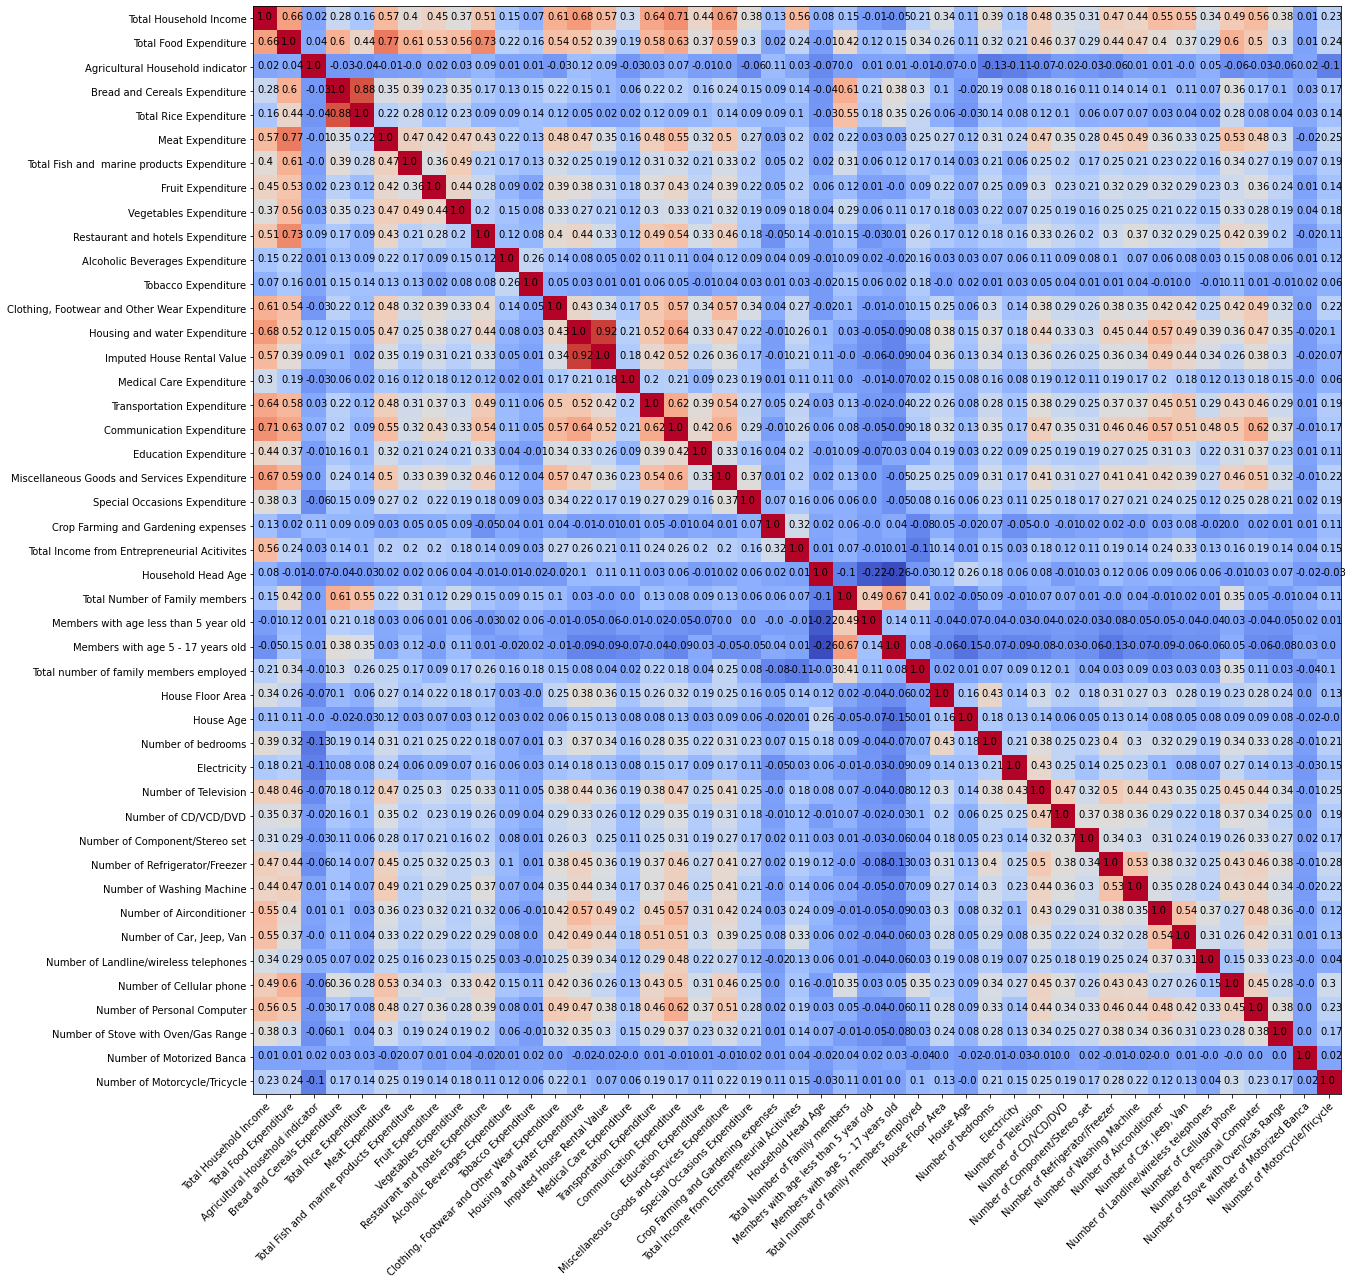

In [4]:
# Import matplotlib.pyplot.
import matplotlib.pyplot as plt
%matplotlib inline

# Select the columns with numerical data.
fies_num = fies.select_dtypes(include=np.number)

# Set fig and ax with a figsize of 24,20.
fig, ax = plt.subplots(figsize=(24,20))

# Use imshow to plot the data in a matrix.
im = ax.imshow(fies_num.corr(), cmap='coolwarm')

# Turn the numerical columns to a list for the axis labels and correlation values.
column_list = fies_num.columns.tolist()
ax.set_xticks(np.arange(len(column_list)), labels=column_list)
plt.setp(ax.get_xticklabels(), rotation_mode="anchor", ha="right", rotation=45)
ax.set_yticks(np.arange(len(column_list)), labels=column_list)

# Set a for loop to plot the correlation values manually.
for row in column_list:
    for col in column_list:
        ax.text(s=round(fies_num.corr()[row][col],2), x=column_list.index(row)-0.35, y=column_list.index(col)+0.05)

# Show the plot.
plt.show()

#### NOTE: This heatmap could have been initiated more efficiently with Seaborn. However, the device used for this analysis does not support Seaborn as of this time.

### Correlation Heatmap
Most of the columns have acceptable correlation with each other (with the exception of breads vs rice expenditure and housing/water expenditure vs imputed house rental value). We can proceed with this for now.

### Features engineering  and model selection with scikit-learn
We can now proceed to do features engineering with scikit-learn. We can also use pipelines for better processing efficiency.

In [5]:
# Split the dataset with train_test_split. Set the 'Total Household Income' column as the target.
from sklearn.model_selection import train_test_split

X = fies.drop(columns='Total Household Income')
y = fies['Total Household Income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Creation of a custom function to sort education attainment of the household head
There are several values in the column 'Household Head Highest Grade Completed'. We can pool these values in terms of the last grade or level they have attained. For example, if the designated value for a row contains the word 'college', the value will be replaced by the word 'college'. This way, we can group the achievements together and assign values to them with the OneHotEncoder. Leaving this column as is will leave too many values that might be difficult for the model to analyze.

In [6]:
# Create function 'last_grade' to sort and pool the achievements of the participants to lessen the categories for analysis.
def last_grade(df):
    # Get unique values in the column and set their strings in lowercase for easier processing.
    grade_values = pd.Series(df['Household Head Highest Grade Completed'].unique())
    grade_values = grade_values.str.lower()
    
    # Group the column values in the following lists to condense the categories.
    undergrad = grade_values[grade_values.str.contains(r'programs$')].tolist()
    grade_school = grade_values[grade_values.str.contains('grade|elementary')].tolist()
    high_school = grade_values[grade_values.str.contains('high school')].tolist()
    none = grade_values[grade_values.str.contains('preschool')].tolist()
    college = grade_values[grade_values.str.contains('college')].tolist()
    other = grade_values[grade_values.str.contains('other')].tolist()
    post_grad = grade_values[grade_values.str.contains('post baccalaureate')].tolist()
    post_secondary = grade_values[grade_values.str.contains('post secondary')].tolist()
    
    # Create a dictionary to house the column values with their labels for the column transformation.
    sort_grade = {'undergraduate_degree' : undergrad,
                  'grade_school' : grade_school,
                  'high_school' : high_school,
                  'none' : none,
                  'college' : college,
                  'other' : other,
                  'post_grad' : post_grad,
                  'post_secondary' : post_secondary}

    # Since dictionaries cannot have lists as keys, each column value will be assigned to the label values that will be used.
    last_grade = {v: key for key, value in sort_grade.items() for v in value}
    
    # Use the pandas map function to label the education attainments for each row.
    df['Household Head Highest Grade Completed'] = df['Household Head Highest Grade Completed'].map(last_grade)
    
    # Return the dataframe.
    return df

### Creation of a custom function to remove object data type columns with excessive number of values.
Another function will be made to ensure that the object data type columns will only have a moderate count of values for analysis. If we convert these columns to dummies or OneHotEncoder, excessive number of columns will be added to the analysis.

In [7]:
# Create 'ohe_string_cols' to minimize the number of columns for the dummies or OneHotEncoder transformation.
def ohe_string_cols(df, unique=10):
    str_cols = df.columns
    col_drop = []
    for col in str_cols:
        if df[col].nunique() > unique:
            col_drop.append(col)
    df.drop(columns=col_drop, inplace=True)
    return df

### Creation of a pipeline to streamline the steps needed to generate predictions
The pipeline process will go through with the use of scikit-learn tools.

In [8]:
# Import necessary scikit-learn functions.
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Input 'last_grade' to the FunctionTransformer.
grade_strings = FunctionTransformer(last_grade)

# Input 'ohe_string_cols' to the FunctionTransformer.
ohe_strings = FunctionTransformer(ohe_string_cols)

# Create a pipeline for the columns with the object data type.
cat_pipeline = Pipeline([('last_grade',grade_strings),
                         ('ohe',ohe_strings),
                         ('onehotencoder',OneHotEncoder(handle_unknown='ignore'))])

# Create a pipeline for the columns with the numeric data type.
num_pipeline = Pipeline([('robustscaler',RobustScaler())])

# Input the two pipelines above for the column transformer and use the 'make_column_selector' to assign the data types for each function.
preprocess = ColumnTransformer(
    [('cat', cat_pipeline, make_column_selector(dtype_include=object)),
    ('num', num_pipeline, make_column_selector(dtype_include=np.number))])

# Use 'LinearRegression' model as the estimator.
lr = LinearRegression()

# Input the column transformer and estimator to a pipeline.
pipe = Pipeline([('preprocess', preprocess),('linearregression', lr)])

# Fit the pipeline.
pipe.fit(X_train, y_train)

# Generate predictions and the score.
predictions = pipe.predict(X_test)
print(pipe.score(X_test, y_test))

# Generate rmse for the predictions and y_test
rmse = mean_squared_error(predictions, y_test, squared=False)

# Print rmse
print(rmse)

0.8887859063728552
94585.00911033023


## Conclusion
The final RMSE value of Php94,585 was given out by the model and a score of 88.88%.   

There are ways to improve this:   
1. Combine the pipeline with a grid search to look for the best parameters and values.
2. Use the grid search to also look for other estimators that might work better with the dataset.
3. Remove unnecessary features through PCA or SelectPercentile while generating new ones with better correlation to the target column.